# **Imports & Settings**

In [12]:
from utils_data_prep import *
import os
import re
import numpy as np

import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds

import whitebox

from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [8]:
#########################
# Initialize Whitebox
#########################
# USER MANUAL: https://whiteboxgeo.com/manual/wbt_book/preface.html

# import whitebox tools class as wbt object
wbt = whitebox.WhiteboxTools()

# toggle on/off geoprocessing tool outputs (optional)
wbt.verbose = False

# set working directory for input/output files to current working directory
wbt.set_working_dir(os.getcwd())

# print whitebox version to verify correctly loading
wbt.version()

"WhiteboxTools v2.4.0 (c) Dr. John Lindsay 2017-2023\n\nWhiteboxTools is an advanced geospatial data analysis platform developed at\nthe University of Guelph's Geomorphometry and Hydrogeomatics Research \nGroup (GHRG). See www.whiteboxgeo.com for more details.\n"


# **Terrain Features**

***OVERVIEW***
* Terrain features are derived from the DEM to characterize the topography and capture features that are critical for identifying and delineating surficial geologic map units. These features provide supplementary data about topography, weathering processes, water drainage patterns, and vegetation that enhance the interpretation of geologic processes and landforms, contributing to more accurate predictions.

* Terrain features may be calculated using a variety of GIS tools. The features below use the Python implementation of Whitebox Tools. Details from the user manual are presented below each tool, and the reader is referred to the home page for more information - https://www.whiteboxgeo.com/manual/wbt_book/preface.html

***PURPOSE***
* Eight terrain features are calculated from the DEM, each providing unique insights into the landscape's characteristics:

    1. **Slope.** Measures the steepness or incline of the terrain. It is critical for identifying areas prone to erosion, landslides, or specific deposition patterns associated with certain geologic map units.

    2. **Profile Curvature.** Indicates the curvature of the terrain in the direction of the slope. It affects the acceleration or deceleration of water flow, which can influence erosion and sediment deposition patterns.

    3. **Planform Curvature.** Measures the curvature perpendicular to the slope direction. It helps in identifying convergent and divergent flow patterns, which are important for understanding water drainage and sediment deposition.

    4. **Standard Deviation of Slope.** Provides a measure of the variability in slope within a given area. It is useful for identifying areas with complex topography, which may correlate with different geologic processes or materials.

    5. **Elevation Percentile.** Measure of local tpi...

## *Multi-directional Hillshade*

* This is strictly for visualizations...

* This tool performs a hillshade operation (also called shaded relief) on an input digital elevation model (DEM) with multiple sources of illumination. The user must specify the name of the input DEM (--dem) and the output hillshade image name (--output). Other parameters that must be specified include the altitude of the illumination sources (--altitude; i.e. the elevation of the sun above the horizon, measured as an angle from 0 to 90 degrees) and the Z conversion factor (--zfactor). The Z conversion factor is only important when the vertical and horizontal units are not the same in the DEM, and the DEM is in a projected coordinate system.

* The hillshade value (HS) of a DEM grid cell is calculate as, HS = tan(s) / [1 - tan(s)2]0.5 x [sin(Alt) / tan(s) - cos(Alt) x sin(Az - a)], where s and a are the local slope gradient and aspect (orientation) respectively and Alt and Az are the illumination source altitude and azimuth respectively. Slope and aspect are calculated using Horn's (1981) 3rd-order finate difference method.

* Lastly, the user must specify whether or not to use full 360-degrees of illumination sources (--full_mode). When this flag is not specified, the tool will perform a weighted summation of the hillshade images from four illumination azimuth positions at 225, 270, 315, and 360 (0) degrees, given weights of 0.1, 0.4, 0.4, and 0.1 respectively. When run in the full 360-degree mode, eight illumination source azimuths are used to calculate the output at 0, 45, 90, 135, 180, 225, 270, and 315 degrees, with weights of 0.15, 0.125, 0.1, 0.05, 0.1, 0.125, 0.15, and 0.2 respectively.

* https://www.whiteboxgeo.com/manual/wbt_book/available_tools/geomorphometric_analysis.html#MultidirectionalHillshade

In [134]:
########################################
# Calculate Multi-directional Hillshade
########################################

# path to DEM
dem_path = r'../data/warren/dem_buffered.tif'
dem_path = os.path.abspath(dem_path)

# path for output GeoTIFF
output_path = r'../data/warren/mdhs.tif'
output_path = os.path.abspath(output_path)


##### calculate mdhs
wbt.multidirectional_hillshade(dem_path, output_path, altitude=30, zfactor=None, full_mode=False)

0

## *Multi-scale Analysis*

* Multiple scales of terrain features can be critical to accurately detect and characterize surficial geologic map units. 

* The DEM will be scaled to multiple resolutions and each of these will then be used to calculate the terrain features.

    * Gaussian filter (3x3 or 5x5 kernel) will be applied to the original DEM

    * The filtered DEM will then be downsampled to several lower resolutions to capture local, intermediate, and global scale topographic features that may be relevant to the ultimate goal of identifying surficial geologic map units.

        * Original DEM has a spatial resolution of 5x5 feet per pixel.

        * Downsample resolutions will be 10x10, 20x20, 100x100, and 200x200 feet per pixel.

    * Terrain features will be calculated directly from downsampled DEMs.
    
    * Scaled Terrain features will then be upsampled and aligned with the original DEM and other features in the dataset.

In [5]:
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject

def resample_image(input_path, new_resolution, output_path):

    with rasterio.open(input_path) as src:

        # calculate the new transform and dimensions based on the new resolution
        dst_transform, dst_width, dst_height = calculate_default_transform(src.crs,                       # source CRS
                                                                           src.crs,                       # destination CRS
                                                                           src.width,                     # source width
                                                                           src.height,                    # source height
                                                                           *src.bounds,                   # source left, bottom, right, top coordinates 
                                                                           resolution=new_resolution)     # destination resolution
        
        # create metadata for new resampled image
        dst_meta = src.meta.copy()
        dst_meta.update({'driver': 'GTiff', 
                         'width': dst_width, 
                         'height': dst_height, 
                         'transform':dst_transform})
        
        # write new image to file with new transform & metadata & resolution
        with rasterio.open(output_path, 'w', **dst_meta) as dst:
            reproject(source=rasterio.band(src, 1), 
                      destination=rasterio.band(dst, 1), 
                      src_transform=src.transform, 
                      src_crs=src.crs, 
                      dst_transform=dst_transform, 
                      dst_crs=src.crs, 
                      resampling=Resampling.cubic)

In [17]:
################################
# Create Multiple Scales of DEM
################################

# path to original dem
dem_path = r'../data/warren/dem_buffered.tif'

# list of resolution(s) to downsample DEM (in native spatial units, which is feet here)
# NOTE: with default 5x5 window for terrain feature calculations, these resolutions will effectively result in 50, 100, 250, 500, and 1000 foot windows (in addition to original scale of 5 foot resolution / 25 foot window)
downsample_resolutions = [10, 20, 50, 100, 200]


##### downsample DEM and save new GeoTIFF images
for res in downsample_resolutions:
    output_path = f"../data/warren/dem_{res}.tif"
    if not os.path.isfile(output_path):
        resample_image(dem_path, res, output_path)

/var/folders/gf/gcyl3xv12kq1njc8q6hm7v2h0000gn/T/ipykernel_35792/1173058429.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


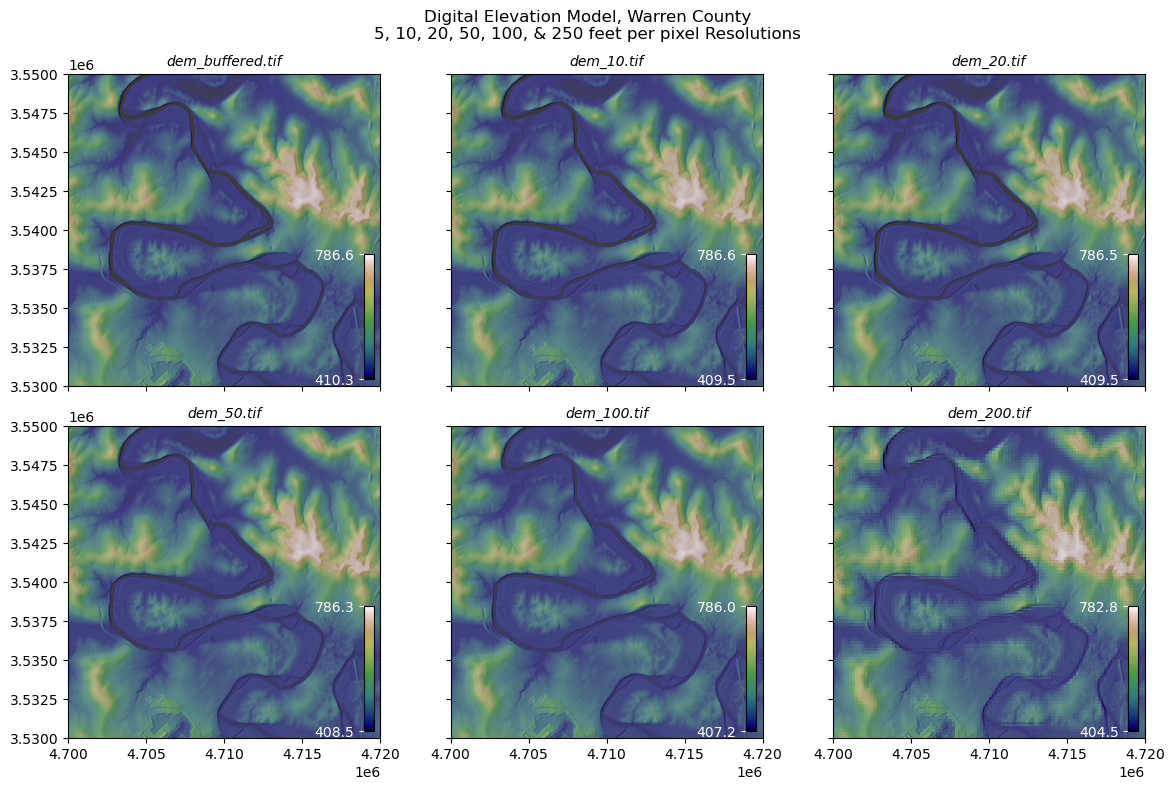

In [158]:
#############################
# Visualize Downsampled DEMs
#############################

# paths to DEMs
dem_paths = glob.glob(r'../data/warren/dem*.tif')
dem_paths.sort(key=lambda x: list(map(int, re.findall(r'\d+', x))))
dem_paths = [dem for dem in dem_paths if not 'dem.tif' in dem]

# path to multi-directional hillshade
mdhs_path = r'../data/warren/mdhs.tif'


##### plot DEMs
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
ax = ax.ravel()

with rasterio.open(mdhs_path) as mdhs:

    for idx, dem in enumerate(dem_paths):
        with rasterio.open(dem) as src:
            window = from_bounds(4700000, 3530000, 4720000, 3550000, src.transform)
            transform = src.window_transform(window)
            data = src.read(1, window=window)
            min_val = np.min(data)
            max_val = np.max(data)

            hidden = ax[idx].imshow(data, cmap='gist_earth')
            
            window2 = from_bounds(4700000, 3530000, 4720000, 3550000, mdhs.transform)
            mdhs_data = mdhs.read(1, window=window2)
            show(mdhs_data, ax=ax[idx], cmap='binary_r', transform=mdhs.window_transform(window2))

            show(data, ax=ax[idx], cmap='gist_earth', transform=transform, alpha=0.6)

            cax = inset_axes(ax[idx], width='3%', height='40%', loc='lower right')
            cbar = fig.colorbar(hidden, cax=cax, ticks=[min_val, max_val])
            cbar.ax.tick_params(colors='white')
            cax.yaxis.set_ticks_position('left')
            ax[idx].set_title(os.path.basename(dem), style='italic', fontsize=10)

plt.suptitle('Digital Elevation Model, Warren County\n5, 10, 20, 50, 100, & 250 feet per pixel Resolutions', y=0.98)
plt.tight_layout()
plt.show()


## *Slope*

This tool calculates slope gradient (i.e. slope steepness in degrees, radians, or percent) for each grid cell in an input digital elevation model (DEM). For DEMs in projected coordinate systems, the tool uses the 3rd-order bivariate Taylor polynomial method described by Florinsky (2016). Based on a polynomial fit of the elevations within the 5x5 neighbourhood surrounding each cell, this method is considered more robust against outlier elevations (noise) than other methods.

* https://www.whiteboxgeo.com/manual/wbt_book/available_tools/geomorphometric_analysis.html#Slope

In [178]:
###################
# Calculate Slopes
###################

# paths to DEMs
dem_paths = glob.glob(r'../data/warren/dem*.tif')
dem_paths.sort(key=lambda x: list(map(int, re.findall(r'\d+', x))))


##### calculate slope
for dem in dem_paths:

    # create output path
    output_path = dem.replace('dem', 'slope')

    # create absolute paths - Whitebox does not like relative paths
    dem = os.path.abspath(dem)
    output_path = os.path.abspath(output_path)

    # calculate slope (default 5x5 pixel window)
    wbt.slope(dem=dem, output=output_path)

/var/folders/gf/gcyl3xv12kq1njc8q6hm7v2h0000gn/T/ipykernel_35792/355561279.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


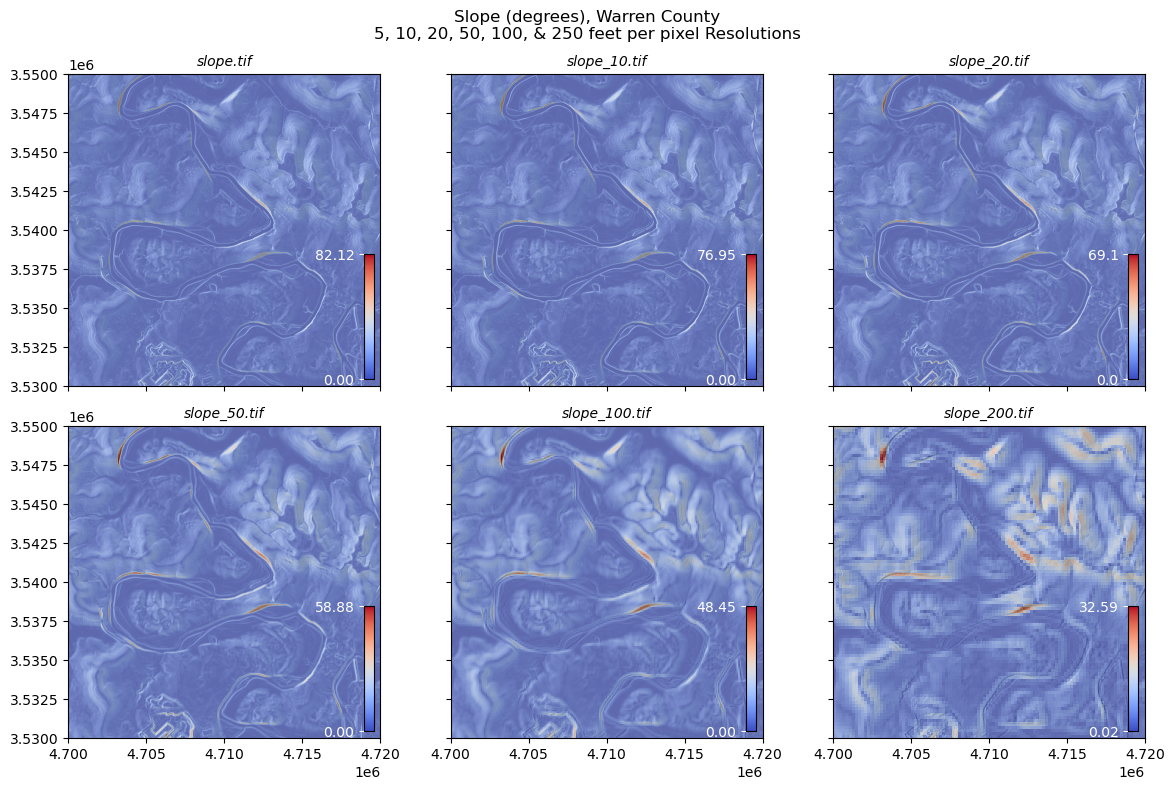

In [164]:
#####################################
# Visualize Downsampled Slope Images
#####################################

# paths to slope images
slope_paths = glob.glob(r'../data/warren/slope*.tif')
slope_paths.sort(key=lambda x: list(map(int, re.findall(r'\d+', x))))

# path to multi-directional hillshade
mdhs_path = r'../data/warren/mdhs.tif'


##### plot slope
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
ax = ax.ravel()

with rasterio.open(mdhs_path) as mdhs:

    for idx, slope in enumerate(slope_paths):
        with rasterio.open(slope) as src:
            window = from_bounds(4700000, 3530000, 4720000, 3550000, src.transform)
            transform = src.window_transform(window)
            data = src.read(1, window=window)
            min_val = np.min(data)
            max_val = np.max(data)

            hidden = ax[idx].imshow(data, cmap='coolwarm', alpha=1)

            window2 = from_bounds(4700000, 3530000, 4720000, 3550000, mdhs.transform)
            mdhs_data = mdhs.read(1, window=window2)
            show(mdhs_data, ax=ax[idx], cmap='binary_r', transform=mdhs.window_transform(window2))

            show(data, ax=ax[idx], cmap='coolwarm', transform=transform, alpha=0.6)

            cax = inset_axes(ax[idx], width='3%', height='40%', loc='lower right')
            cbar = fig.colorbar(hidden, cax=cax, ticks=[min_val, max_val])
            cbar.ax.tick_params(colors='white')
            cax.yaxis.set_ticks_position('left')
            ax[idx].set_title(os.path.basename(slope), style='italic', fontsize=10)

plt.suptitle('Slope (degrees), Warren County\n5, 10, 20, 50, 100, & 250 feet per pixel Resolutions', y=0.98)
plt.tight_layout()
plt.show()

## *Profile Curvature*

This tool calculates the profile (or vertical) curvature, or the rate of change in slope along a flow line, from a digital elevation model (DEM). It is the curvature of a normal section having a common tangent line with a slope line at a given point on the surface (Florinsky, 2017). This variable has an unbounded range that can take either positive or negative values. Positive values of the index are indicative of flow acceleration while negative profile curvature values indicate flow deceleration. Profile curvature is measured in units of m-1. For DEMs in projected coordinate systems, the tool uses the 3rd-order bivariate Taylor polynomial method described by Florinsky (2016). Based on a polynomial fit of the elevations within the 5x5 neighbourhood surrounding each cell, this method is considered more robust against outlier elevations (noise) than other methods.

* https://www.whiteboxgeo.com/manual/wbt_book/available_tools/geomorphometric_analysis.html#ProfileCurvature

In [59]:
###############################
# Calculate Profile Curvatures
###############################

# paths to DEMs
dem_paths = glob.glob(r'../data/warren/dem*.tif')
dem_paths.sort(key=lambda x: list(map(int, re.findall(r'\d+', x))))


##### calculate log profile curvature
for dem in dem_paths:

    # create output path
    output_path = dem.replace('dem', 'procurv')

    # create absolute paths - Whitebox does not like relative paths
    dem = os.path.abspath(dem)
    output_path = os.path.abspath(output_path)

    # calculate profile curvature (default 5x5 pixel window)
    wbt.profile_curvature(dem=dem, output=output_path, log=True)

/var/folders/gf/gcyl3xv12kq1njc8q6hm7v2h0000gn/T/ipykernel_35792/2585258361.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


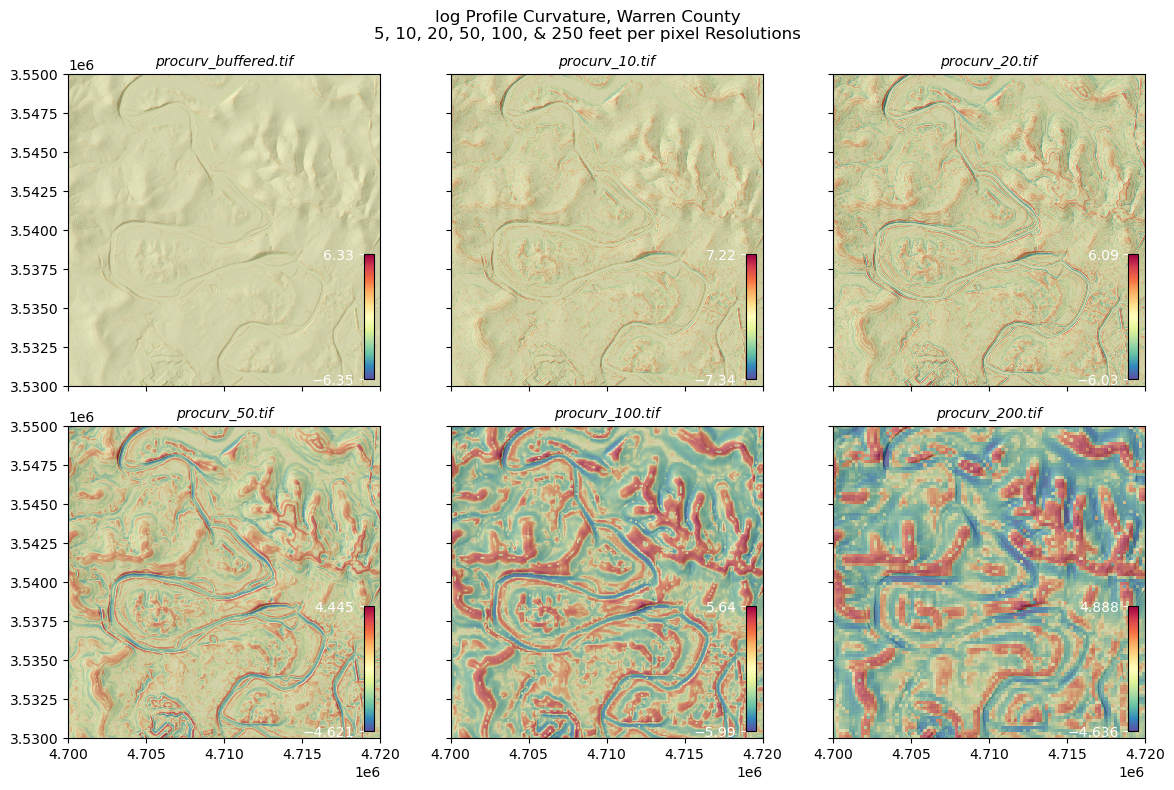

In [167]:
#################################################
# Visualize Downsampled Profile Curvature Images
#################################################

# paths to profile curvature images
procurv_paths = glob.glob(r'../data/warren/procurv*.tif')
procurv_paths.sort(key=lambda x: list(map(int, re.findall(r'\d+', x))))

# path to multi-directional hillshade
mdhs_path = r'../data/warren/mdhs.tif'


##### plot log profile curvature
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
ax = ax.ravel()

with rasterio.open(mdhs_path) as mdhs:

    for idx, procurv in enumerate(procurv_paths):
        with rasterio.open(procurv) as src:
            window = from_bounds(4700000, 3530000, 4720000, 3550000, src.transform)
            transform = src.window_transform(window)
            data = src.read(1, window=window)
            min_val = np.min(data)
            max_val = np.max(data)

            hidden = ax[idx].imshow(data, cmap='Spectral_r')

            window2 = from_bounds(4700000, 3530000, 4720000, 3550000, mdhs.transform)
            mdhs_data = mdhs.read(1, window=window2)
            show(mdhs_data, ax=ax[idx], cmap='binary_r', transform=mdhs.window_transform(window2))

            show(data, ax=ax[idx], cmap='Spectral_r', transform=transform, alpha=0.6)

            cax = inset_axes(ax[idx], width='3%', height='40%', loc='lower right')
            cbar = fig.colorbar(hidden, cax=cax, ticks=[min_val, max_val])
            cbar.ax.tick_params(colors='white')
            cax.yaxis.set_ticks_position('left')
            ax[idx].set_title(os.path.basename(procurv), style='italic', fontsize=10)

plt.suptitle('log Profile Curvature, Warren County\n5, 10, 20, 50, 100, & 250 feet per pixel Resolutions', y=0.98)
plt.tight_layout()
plt.show()

## *Planform Curvature*

This tool calculates the plan (or contour) curvature from a digital elevation model (DEM). Plan curvature is the curvature of a contour line at a given point on the topographic surface (Florinsky, 2017). This variable has an unbounded range that can take either positive or negative values. Positive values of the index are indicative of flow divergence while negative plan curvature values indicate flow convergence. Thus plan curvature is similar to tangential curvature, although the literature suggests that the latter is more numerically stable (Wilson, 2018). Plan curvature is measured in units of m-1. method described by Florinsky (2016). Based on a polynomial fit of the elevations within the 5x5 neighbourhood surrounding each cell, this method is considered more robust against outlier elevations (noise) than other methods. 

* https://www.whiteboxgeo.com/manual/wbt_book/available_tools/geomorphometric_analysis.html#PlanCurvature

In [53]:
################################
# Calculate Planform Curvatures
################################

# paths to DEMs
plancurv_paths = glob.glob(r'../data/warren/dem*.tif')
plancurv_paths.sort(key=lambda x: list(map(int, re.findall(r'\d+', x))))


##### calculate log plan curvature
for dem in dem_paths:

    # create output path
    output_path = dem.replace('dem', 'plancurv')

    # create absolute paths - Whitebox does not like relative paths
    dem = os.path.abspath(dem)
    output_path = os.path.abspath(output_path)

    # calculate log plan curvature (default 5x5 pixel window)
    wbt.plan_curvature(dem=dem, output=output_path, log=True)

/var/folders/gf/gcyl3xv12kq1njc8q6hm7v2h0000gn/T/ipykernel_35792/3771731571.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


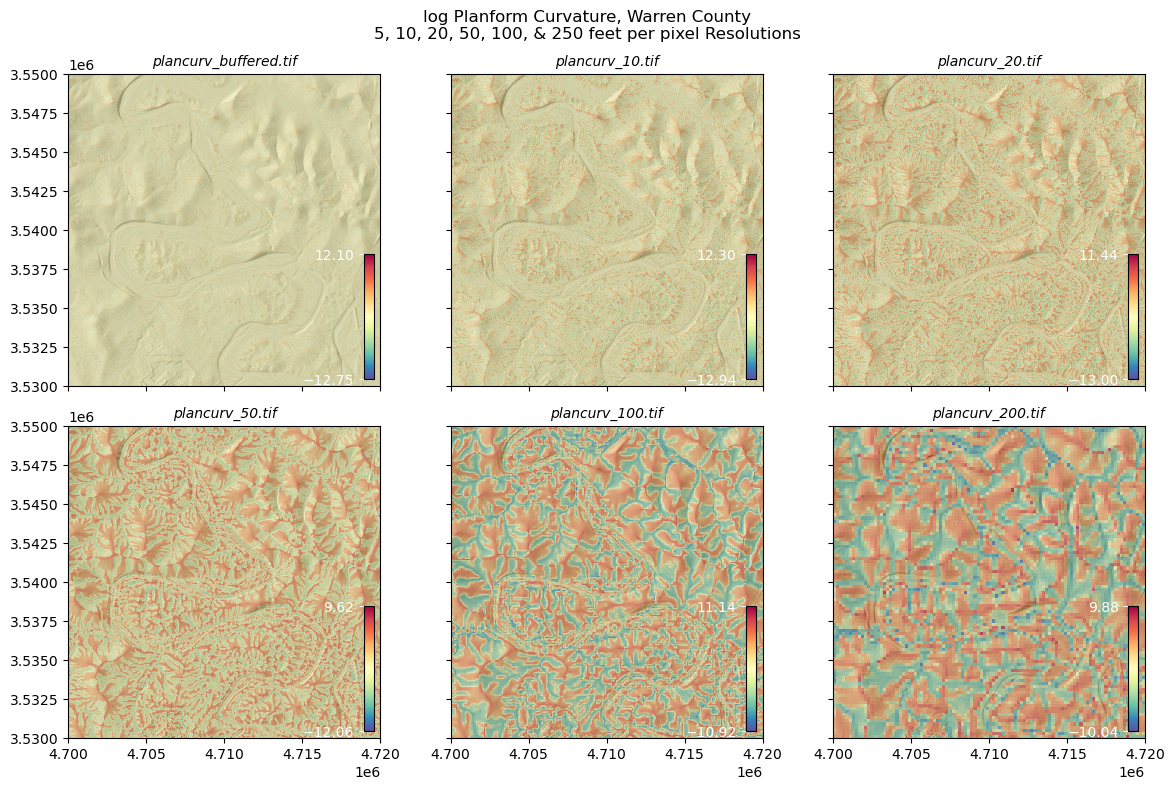

In [168]:
#################################################
# Visualize Downsampled Planform Curvature Images
#################################################

# paths to planform curvature images
plancurv_paths = glob.glob(r'../data/warren/plancurv*.tif')
plancurv_paths.sort(key=lambda x: list(map(int, re.findall(r'\d+', x))))

# path to multi-directional hillshade
mdhs_path = r'../data/warren/mdhs.tif'


##### plot log panform curvature
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
ax = ax.ravel()

with rasterio.open(mdhs_path) as mdhs:

    for idx, plancurv in enumerate(plancurv_paths):
        with rasterio.open(plancurv) as src:
            window = from_bounds(4700000, 3530000, 4720000, 3550000, src.transform)
            transform = src.window_transform(window)
            data = src.read(1, window=window)
            min_val = np.min(data)
            max_val = np.max(data)

            hidden = ax[idx].imshow(data, cmap='Spectral_r')

            window2 = from_bounds(4700000, 3530000, 4720000, 3550000, mdhs.transform)
            mdhs_data = mdhs.read(1, window=window2)
            show(mdhs_data, ax=ax[idx], cmap='binary_r', transform=mdhs.window_transform(window2))

            show(data, ax=ax[idx], cmap='Spectral_r', transform=transform, alpha=0.6)

            cax = inset_axes(ax[idx], width='3%', height='40%', loc='lower right')
            cbar = fig.colorbar(hidden, cax=cax, ticks=[min_val, max_val])
            cbar.ax.tick_params(colors='white')
            cax.yaxis.set_ticks_position('left')
            ax[idx].set_title(os.path.basename(plancurv), style='italic', fontsize=10)

plt.suptitle('log Planform Curvature, Warren County\n5, 10, 20, 50, 100, & 250 feet per pixel Resolutions', y=0.98)
plt.tight_layout()
plt.show()

## *Standard Deviation of Slope*

Calculates the standard deviation of slope from an input DEM, a metric of roughness described by Grohmann et al., (2011).

* https://www.whiteboxgeo.com/manual/wbt_book/available_tools/geomorphometric_analysis.html#StandardDeviationOfSlope



In [162]:
#################################################
# Calculate Standard Deviation of Slope from DEM
#################################################

# paths to DEMs
dem_paths = glob.glob(r'../data/warren/dem*.tif')
dem_paths.sort(key=lambda x: list(map(int, re.findall(r'\d+', x))))


##### calculate standard deviation of slope
for dem in dem_paths:

    # create output path
    output_path = dem.replace('dem', 'stdslope')

    # create absolute paths - Whitebox does not like relative paths
    dem = os.path.abspath(dem)
    output_path = os.path.abspath(output_path)

    # calculate standard deviation of slope (using same window as other terrain features)
    wbt.standard_deviation_of_slope(dem, output_path, zfactor=None, filterx=5, filtery=5)

/var/folders/gf/gcyl3xv12kq1njc8q6hm7v2h0000gn/T/ipykernel_35792/289601930.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


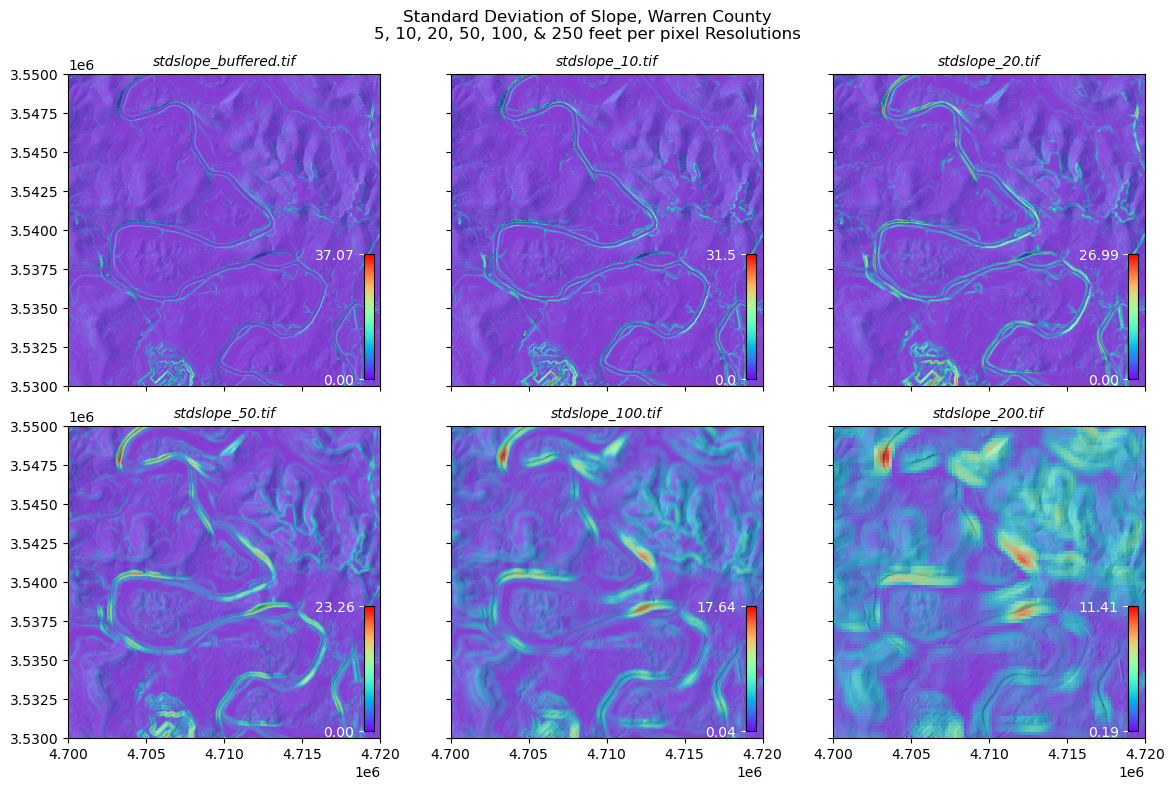

In [179]:
###########################################################
# Visualize Downsampled Standard Deviation of Slope Images
###########################################################

# paths to standard deviation of slope images
stdslope_paths = glob.glob(r'../data/warren/stdslope*.tif')
stdslope_paths.sort(key=lambda x: list(map(int, re.findall(r'\d+', x))))

# path to multi-directional hillshade
mdhs_path = r'../data/warren/mdhs.tif'


##### plot log panform curvature
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
ax = ax.ravel()

with rasterio.open(mdhs_path) as mdhs:

    for idx, stdslope in enumerate(stdslope_paths):
        with rasterio.open(stdslope) as src:
            window = from_bounds(4700000, 3530000, 4720000, 3550000, src.transform)
            transform = src.window_transform(window)
            data = src.read(1, window=window)
            min_val = np.min(data)
            max_val = np.max(data)

            hidden = ax[idx].imshow(data, cmap='rainbow')

            window2 = from_bounds(4700000, 3530000, 4720000, 3550000, mdhs.transform)
            mdhs_data = mdhs.read(1, window=window2)
            show(mdhs_data, ax=ax[idx], cmap='binary_r', transform=mdhs.window_transform(window2))

            show(data, ax=ax[idx], cmap='rainbow', transform=transform, alpha=0.6)

            cax = inset_axes(ax[idx], width='3%', height='40%', loc='lower right')
            cbar = fig.colorbar(hidden, cax=cax, ticks=[min_val, max_val])
            cbar.ax.tick_params(colors='white')
            cax.yaxis.set_ticks_position('left')
            ax[idx].set_title(os.path.basename(stdslope), style='italic', fontsize=10)

plt.suptitle('Standard Deviation of Slope, Warren County\n5, 10, 20, 50, 100, & 250 feet per pixel Resolutions', y=0.98)
plt.tight_layout()
plt.show()

## *Elevation Percentile*

Elevation percentile (EP) is a measure of local topographic position (LTP). It expresses the vertical position for a digital elevation model (DEM) grid cell (z0) as the percentile of the elevation distribution within the filter window, such that:

EP = counti∈C(zi < z0) x (100 / nC)

where z0 is the elevation of the window's center grid cell, zi is the elevation of cell i contained within the neighboring set C, and nC is the number of grid cells contained within the window.

EP is unsigned and expressed as a percentage, bound between 0% and 100%. Quantile-based estimates (e.g., the median and interquartile range) are often used in nonparametric statistics to provide data variability estimates without assuming the distribution is normal. Thus, EP is largely unaffected by irregularly shaped elevation frequency distributions or by outliers in the DEM, resulting in a highly robust metric of LTP. In fact, elevation distributions within small to medium sized neighborhoods often exhibit skewed, multimodal, and non-Gaussian distributions, where the occurrence of elevation errors can often result in distribution outliers. Thus, based on these statistical characteristics, EP is considered one of the most robust representation of LTP.

* https://www.whiteboxgeo.com/manual/wbt_book/available_tools/geomorphometric_analysis.html#ElevPercentile

In [181]:
##########################################
# Calculate Elevation Percentile from DEM
##########################################

# paths to DEMs
dem_paths = glob.glob(r'../data/warren/dem*.tif')
dem_paths.sort(key=lambda x: list(map(int, re.findall(r'\d+', x))))


##### calculate elevation percentile
for dem in dem_paths:

    # create output path
    output_path = dem.replace('dem', 'ep')

    # create absolute paths - Whitebox does not like relative paths
    dem = os.path.abspath(dem)
    output_path = os.path.abspath(output_path)

    # calculate elevation percentile (using same window as other terrain features)
    wbt.elev_percentile(dem, output_path, filterx=5, filtery=5, sig_digits=2)

/var/folders/gf/gcyl3xv12kq1njc8q6hm7v2h0000gn/T/ipykernel_35792/199669486.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


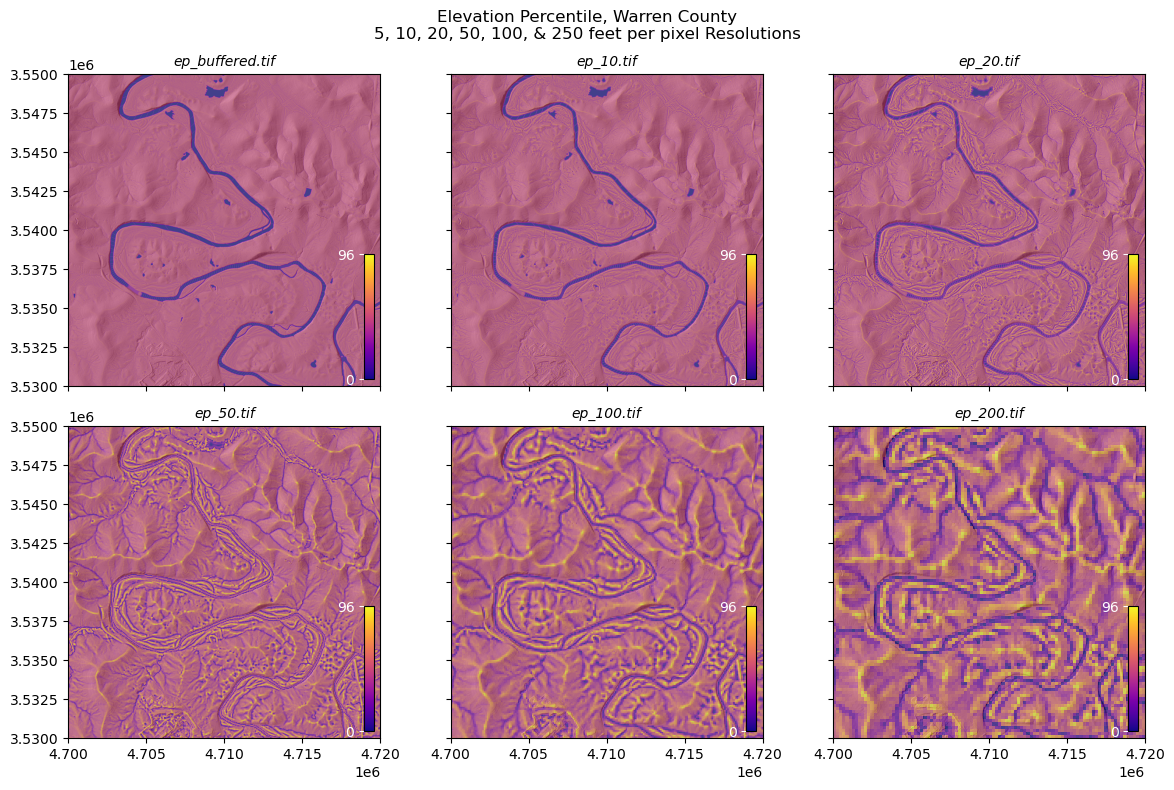

In [182]:
####################################################
# Visualize Downsampled Elevation Percentile Images
####################################################

# paths to elevation percentile images
ep_paths = glob.glob(r'../data/warren/ep*.tif')
ep_paths.sort(key=lambda x: list(map(int, re.findall(r'\d+', x))))

# path to multi-directional hillshade
mdhs_path = r'../data/warren/mdhs.tif'


##### plot log panform curvature
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
ax = ax.ravel()

with rasterio.open(mdhs_path) as mdhs:

    for idx, ep in enumerate(ep_paths):
        with rasterio.open(ep) as src:
            window = from_bounds(4700000, 3530000, 4720000, 3550000, src.transform)
            transform = src.window_transform(window)
            data = src.read(1, window=window)
            min_val = np.min(data)
            max_val = np.max(data)

            hidden = ax[idx].imshow(data, cmap='plasma')

            window2 = from_bounds(4700000, 3530000, 4720000, 3550000, mdhs.transform)
            mdhs_data = mdhs.read(1, window=window2)
            show(mdhs_data, ax=ax[idx], cmap='binary_r', transform=mdhs.window_transform(window2))

            show(data, ax=ax[idx], cmap='plasma', transform=transform, alpha=0.6)

            cax = inset_axes(ax[idx], width='3%', height='40%', loc='lower right')
            cbar = fig.colorbar(hidden, cax=cax, ticks=[min_val, max_val])
            cbar.ax.tick_params(colors='white')
            cax.yaxis.set_ticks_position('left')
            ax[idx].set_title(os.path.basename(ep), style='italic', fontsize=10)

plt.suptitle('Elevation Percentile, Warren County\n5, 10, 20, 50, 100, & 250 feet per pixel Resolutions', y=0.98)
plt.tight_layout()
plt.show()

# **PCA Multi-Scale Features**